## Training with TELSEM emissivity

Using windsat grid

In [19]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model

import sys
import os
sys.path.append("../../")

from src.processing import windsat_datacube, model_preprocess, \
    telsem_datacube, doy2month_mapping
from src.model import xy_split, plot_history


# Global variables
swath = 1

swath2char = {
    0 : "A",
    1 : "D"
}

# Paths 
models_folder = "../../models/"


In [2]:
#Load the dataset from the folder
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)
swath_ds= model_preprocess(ds, swath_sector= swath) # Now training DESCENDING pass
swath_ds

<xarray.Dataset> Size: 896MB
Dimensions:         (day_number: 24, latitude_grid: 720, longitude_grid: 1440)
Coordinates:
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
  * latitude_grid   (latitude_grid) int32 3kB 0 1 2 3 4 ... 715 716 717 718 719
  * longitude_grid  (longitude_grid) int32 6kB 0 1 2 3 4 ... 1436 1437 1438 1439
Data variables:
    surtep_ERA5     (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
    tbtoa_18Ghz_V   (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_18Ghz_H   (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_V   (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_H   (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_18Ghz      (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_37Ghz      (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [3]:
telsem_folder = "../../data/processed/WinsatEmiss/"
telsem_ds = telsem_datacube(telsem_folder)
telsem_ds

<xarray.Dataset> Size: 398MB
Dimensions:  (month: 12, latitude_grid: 720, longitude_grid: 1440)
Coordinates:
  * month    (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: latitude_grid, longitude_grid
Data variables:
    Emis19V  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis19H  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis37V  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis37H  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    lat      (month, latitude_grid) float32 35kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    lon      (month, longitude_grid) float32 69kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [4]:
# Create an atlas dataframe with all the months:
telsem_df = telsem_ds.to_dataframe().dropna().reset_index("month")
telsem_df

month   Emis19V   Emis19H   Emis37V   Emis37H  \
latitude_grid longitude_grid                                                  
4             0                   1  0.838461  0.642331  0.850453  0.687476   
              1                   1  0.838612  0.642670  0.850646  0.687777   
              2                   1  0.838762  0.643009  0.850838  0.688078   
              3                   1  0.838912  0.643348  0.851031  0.688379   
              4                   1  0.839063  0.643688  0.851224  0.688679   
...                             ...       ...       ...       ...       ...   
693           609                12  0.929797  0.854530  0.850951  0.786876   
              610                12  0.929314  0.854520  0.845948  0.783754   
              611                12  0.928832  0.854509  0.840944  0.780632   
              612                12  0.929997  0.855679  0.836587  0.777149   
694           589                12  0.918187  0.844714  0.832307  0.772072   

                                 lat      lon  
latitude_grid longitude_grid                   
4             0              -88.875  180.125  
              1              -88.875  180.375  
              2              -88.875  180.625  
              3              -88.875  180.875  
              4              -88.875  181.125  
...                              ...      ...  
693           609             83.375  332.375  
              610             83.375  332.625  
              611             83.375  332.875  
              612             83.375  333.125  
694           589             83.625  327.375  

[4051772 rows x 7 columns]

In [5]:
# simillarly with windsat data

# Select the necessary dvars
d_vars = [
    "surtep_ERA5",
    "lat",
    "lon",
    "tbtoa_18Ghz_V",
    "tbtoa_18Ghz_H",
    "tbtoa_37Ghz_V",
    "tbtoa_37Ghz_H",
]

swath_ds = swath_ds[d_vars]

swath_df = swath_ds.to_dataframe().dropna().reset_index("day_number")
swath_df

day_number  surtep_ERA5     lat      lon  \
latitude_grid longitude_grid                                             
138           442                      1   280.897614 -55.375  290.625   
139           440                      1   280.623657 -55.125  290.125   
              441                      1   280.168365 -55.125  290.375   
              442                      1   279.957825 -55.125  290.625   
140           434                      1   281.620422 -54.875  288.625   
...                                  ...          ...     ...      ...   
640           803                    349   275.467773  70.125   20.875   
642           808                    349   279.481720  70.625   22.125   
              809                    349   279.285858  70.625   22.375   
              810                    349   278.693848  70.625   22.625   
              811                    349   276.700043  70.625   22.875   

                              tbtoa_18Ghz_V  tbtoa_18Ghz_H  tbtoa_37Ghz_V  \
latitude_grid longitude_grid                                                
138           442                232.017487     196.492493     247.942505   
139           440                233.317490     197.602493     248.967499   
              441                245.017502     221.404999     256.325012   
              442                248.024994     227.022491     256.962494   
140           434                216.589996     164.807495     242.432495   
...                                     ...            ...            ...   
640           803                202.009995     141.417496     210.697495   
642           808                194.354996     123.147499     206.949997   
              809                201.444992     136.897491     209.597504   
              810                206.940002     148.145004     211.679993   
              811                209.517487     153.860001     212.699997   

                              tbtoa_37Ghz_H  
latitude_grid longitude_grid                 
138           442                224.702499  
139           440                225.812500  
              441                241.839996  
              442                242.922485  
140           434                211.674988  
...                                     ...  
640           803                159.542511  
642           808                146.887497  
              809                156.194992  
              810                163.494995  
              811                167.037506  

[1089854 rows x 8 columns]

In [6]:
# Map the day of the year (day_number) into the month:
# day_mapping = []
# days_in_months = [31,29,31,30,31,30,31,31,30,31,30,31]

# for i, n in enumerate(days_in_months):
#     to_add = [i +1] * n
#     day_mapping.extend(to_add)

day_mapping = doy2month_mapping()

swath_df["month"] = swath_df["day_number"].apply(lambda x: day_mapping[x])
# drop the day_number column
swath_df = swath_df.drop(columns="day_number")

swath_df

surtep_ERA5     lat      lon  tbtoa_18Ghz_V  \
latitude_grid longitude_grid                                                
138           442              280.897614 -55.375  290.625     232.017487   
139           440              280.623657 -55.125  290.125     233.317490   
              441              280.168365 -55.125  290.375     245.017502   
              442              279.957825 -55.125  290.625     248.024994   
140           434              281.620422 -54.875  288.625     216.589996   
...                                   ...     ...      ...            ...   
640           803              275.467773  70.125   20.875     202.009995   
642           808              279.481720  70.625   22.125     194.354996   
              809              279.285858  70.625   22.375     201.444992   
              810              278.693848  70.625   22.625     206.940002   
              811              276.700043  70.625   22.875     209.517487   

                              tbtoa_18Ghz_H  tbtoa_37Ghz_V  tbtoa_37Ghz_H  \
latitude_grid longitude_grid                                                
138           442                196.492493     247.942505     224.702499   
139           440                197.602493     248.967499     225.812500   
              441                221.404999     256.325012     241.839996   
              442                227.022491     256.962494     242.922485   
140           434                164.807495     242.432495     211.674988   
...                                     ...            ...            ...   
640           803                141.417496     210.697495     159.542511   
642           808                123.147499     206.949997     146.887497   
              809                136.897491     209.597504     156.194992   
              810                148.145004     211.679993     163.494995   
              811                153.860001     212.699997     167.037506   

                              month  
latitude_grid longitude_grid         
138           442                 1  
139           440                 1  
              441                 1  
              442                 1  
140           434                 1  
...                             ...  
640           803                12  
642           808                12  
              809                12  
              810                12  
              811                12  

[1089854 rows x 8 columns]

In [7]:
# Inner join the telsem df and the ascending df
combined_df = pd.merge(left=swath_df, right=telsem_df, how="inner")

# Drop the month column
combined_df = combined_df.drop(columns="month")
combined_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,Emis19V,Emis19H,Emis37V,Emis37H
0,280.897614,-55.375,290.625,232.017487,196.492493,247.942505,224.702499,0.867672,0.764766,0.899219,0.819995
1,280.623657,-55.125,290.125,233.317490,197.602493,248.967499,225.812500,0.873205,0.767411,0.889130,0.796051
2,280.168365,-55.125,290.375,245.017502,221.404999,256.325012,241.839996,0.893535,0.800330,0.904959,0.827316
3,279.957825,-55.125,290.625,248.024994,227.022491,256.962494,242.922485,0.907035,0.827858,0.914358,0.850761
4,281.620422,-54.875,288.625,216.589996,164.807495,242.432495,211.674988,0.796748,0.642067,0.848947,0.718979
...,...,...,...,...,...,...,...,...,...,...,...
1089849,275.467773,70.125,20.875,202.009995,141.417496,210.697495,159.542511,0.665505,0.413298,0.703039,0.440390
1089850,279.481720,70.625,22.125,194.354996,123.147499,206.949997,146.887497,0.669632,0.419112,0.707013,0.448490
1089851,279.285858,70.625,22.375,201.444992,136.897491,209.597504,156.194992,0.670714,0.420704,0.707621,0.449943
1089852,278.693848,70.625,22.625,206.940002,148.145004,211.679993,163.494995,0.671796,0.422296,0.708228,0.451395


In [8]:

def build_model(n_vars: int, info:bool = False):
    
    model = Sequential([
        Input((n_vars,)),
        BatchNormalization(),
        Dense(30,activation="linear", name = "hiddenLayer1"),
        Dense(20,activation="relu", name = "hiddenLayer2"),
        Dense(10,activation="relu", name = "hiddenLayer3"),
        Dense(1,activation="relu", name = "outputLayer")
    ])
    model.compile(
        optimizer = Adam(learning_rate=5e-4),
        loss ="mse",
        metrics = ["mse"]
    )

    if info:
        model.summary()

    return model

### NOTE: 
The training loss for the same model and training parameters went up a few kelvins,
it looks like the latitude and longitude are relevant training variables.

try to wrapp longitude as we did before, using sin function

In [9]:
combined_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
combined_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

In [10]:
# Now we can split the dataframe and train the model

X, y = xy_split(combined_df, y_column= "surtep_ERA5")
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state= 13)

model = build_model(n_vars=len(combined_df.columns) - 1, info=True)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,211 (4.73 KB)

 Trainable params: 1,191 (4.65 KB)

 Non-trainable params: 20 (80.00 B)

In [11]:
# Callbacks
callback = EarlyStopping(
    monitor = "loss",
    patience = 100,
    min_delta = 0.01,
    verbose=2,
    restore_best_weights = True
)
# checkpoints = ModelCheckpoint(
#     filepath = os.path.join(output_folder, "checkpoint.keras"),
#     verbose = 1
# )

history = model.fit(
    x_train,
    y_train,
    epochs=1000,
    batch_size = 512,
    validation_data=(x_test,y_test),
    callbacks=[callback],
    verbose = 2
)

finished_at = datetime.now().strftime(r"%Y_%m_%dT%H%M%S")



Epoch 1/1000
1491/1491 - 3s - 2ms/step - loss: 25656.9395 - mse: 25656.9395 - val_loss: 262.3514 - val_mse: 262.3514
Epoch 2/1000
1491/1491 - 2s - 1ms/step - loss: 88.8690 - mse: 88.8690 - val_loss: 54.0333 - val_mse: 54.0333
Epoch 3/1000
1491/1491 - 2s - 1ms/step - loss: 43.1619 - mse: 43.1619 - val_loss: 31.0387 - val_mse: 31.0387
Epoch 4/1000
1491/1491 - 2s - 1ms/step - loss: 25.3322 - mse: 25.3322 - val_loss: 20.0599 - val_mse: 20.0599
Epoch 5/1000
1491/1491 - 2s - 1ms/step - loss: 17.6130 - mse: 17.6130 - val_loss: 16.7606 - val_mse: 16.7606
Epoch 6/1000
1491/1491 - 2s - 1ms/step - loss: 14.4057 - mse: 14.4057 - val_loss: 13.8673 - val_mse: 13.8673
Epoch 7/1000
1491/1491 - 2s - 1ms/step - loss: 12.6705 - mse: 12.6705 - val_loss: 12.0284 - val_mse: 12.0284
Epoch 8/1000
1491/1491 - 2s - 1ms/step - loss: 11.8082 - mse: 11.8082 - val_loss: 11.8512 - val_mse: 11.8512
Epoch 9/1000
1491/1491 - 2s - 1ms/step - loss: 11.2597 - mse: 11.2597 - val_loss: 10.6880 - val_mse: 10.6880
Epoch 10/10

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='log(mse [K])'>,
        <Axes: title={'center': 'Epochs after loss < 10'}, xlabel='Epoch', ylabel='mse [K]'>],
       dtype=object))

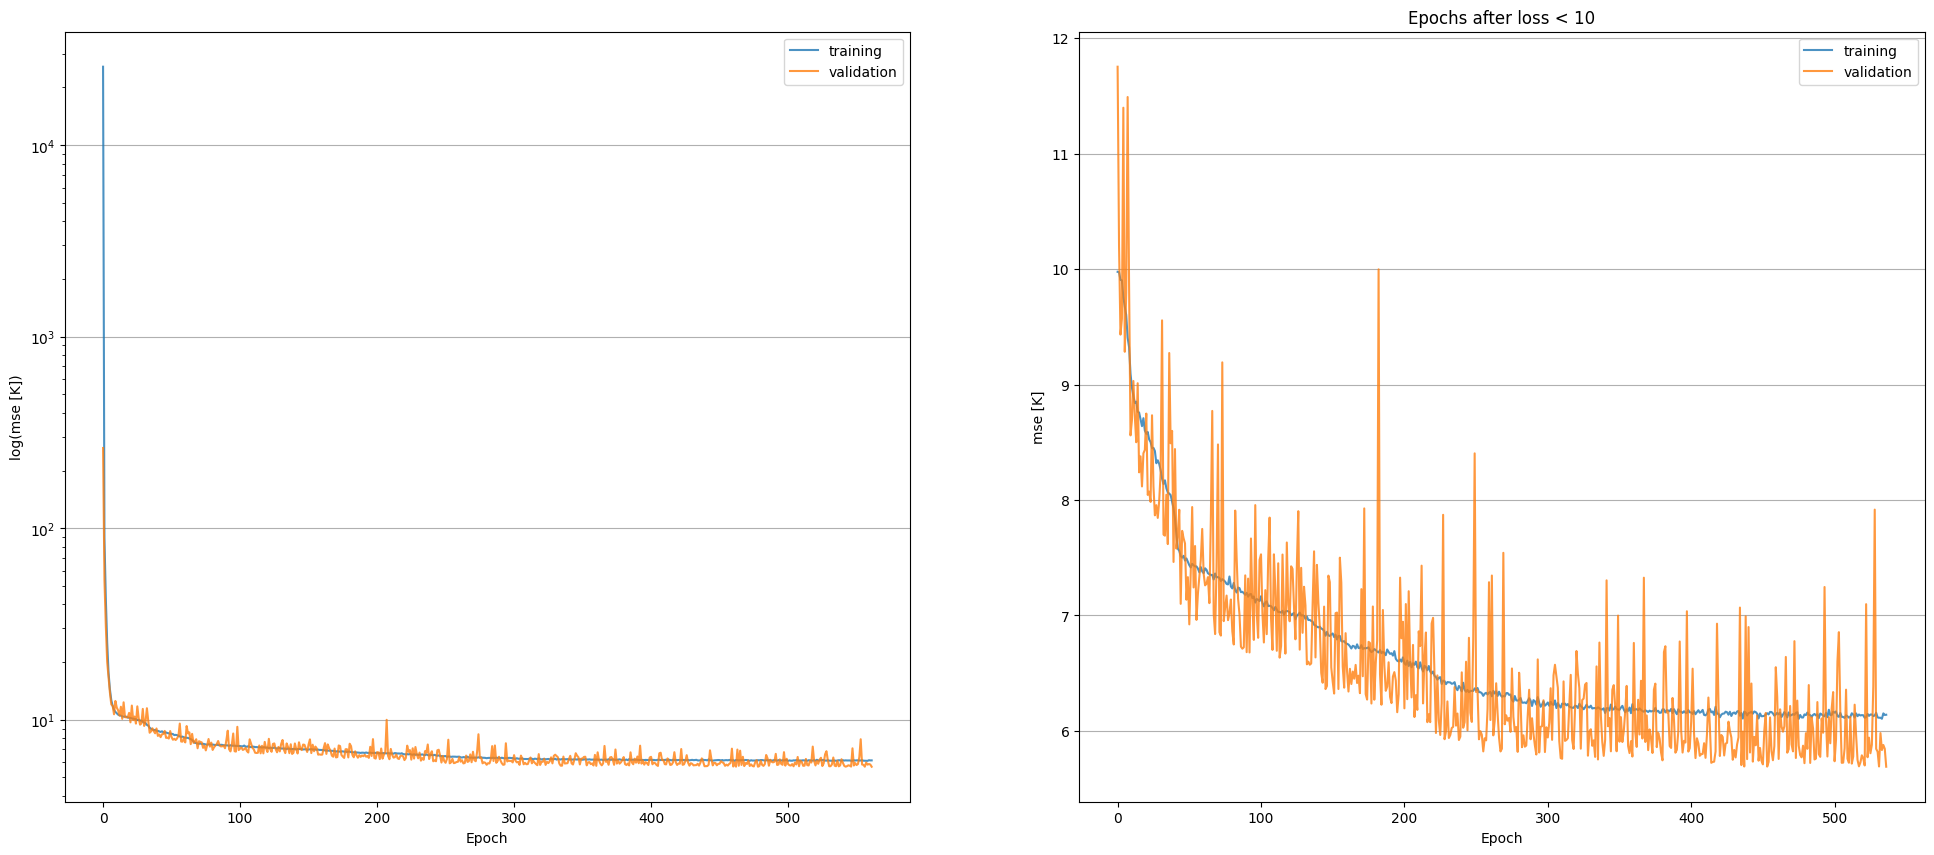

In [17]:
plot_history(history.history, loss_threshold= 10)

In [20]:
model_path = os.path.join(models_folder, f"local_windsatv2_{swath2char[swath]}_{finished_at}.keras")
save_model(model, model_path)

# Save the training history:s
history_path = os.path.join(models_folder, f"local_windsatv2_{swath2char[swath]}_{finished_at}_history")

with open(history_path,"wb") as hfile:
    pickle.dump(history.history, hfile)